# CVPR2021 安全AI挑战者计划第六期：ImageNet无限制对抗攻击

## GPU Info

In [ ]:
!nvidia-smi

Wed Mar 31 03:25:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download Data & Insatll pkg 

| 名称         | 大小     |                           Link |
| :----------- | :------- | ------------------------------: |
| imagenet_round1_210122.zip | 212.89MB |  https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531853/imagenet_round1_210122.zip  |

In [1]:
!rm -rf /content/sample_data
!rm -rf /content/imagenet_round2_210325.zip
!rm -rf /content/dataset

# 复赛
!wget https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531853/imagenet_round2_210325.zip

!unzip -q imagenet_round2_210325.zip 
!unzip -q /content/imagenet_round2_210325/images.zip 

--2021-03-31 08:33:48--  https://tianchi-competition.oss-cn-hangzhou.aliyuncs.com/531853/imagenet_round2_210325.zip
Resolving tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)... 118.31.232.194
Connecting to tianchi-competition.oss-cn-hangzhou.aliyuncs.com (tianchi-competition.oss-cn-hangzhou.aliyuncs.com)|118.31.232.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223167879 (213M) [application/zip]
Saving to: ‘imagenet_round2_210325.zip’

imagenet_round2_210 100%[===================>] 212.83M  10.3MB/s    in 29s     

2021-03-31 08:34:18 (7.43 MB/s) - ‘imagenet_round2_210325.zip’ saved [223167879/223167879]



In [2]:
!mkdir dataset
!mv images dataset
!cp -r /content/imagenet_round2_210325/dev.csv /content/dataset/
!rm -rf im*
!rm -rf dev.csv

In [3]:
!pip install advertorch
!pip install efficientnet_pytorch

     |████████████████████████████████| 5.7MB 6.2MB/s 
  Created wheel for advertorch: filename=advertorch-0.2.3-cp37-none-any.whl size=5696220 sha256=fa2b738d576612e8861e920fe312de880919755dfa921d48a3445ee58afe8575
  Stored in directory: /root/.cache/pip/wheels/9b/53/6e/6b2509701b0da68443fa3d4499733f5455d6d583afa8c46676
Successfully built advertorch
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-cp37-none-any.whl size=16031 sha256=d45c78e2e0de66007648e027caf682a9624410d80a36b85bae4e3e5ce2719681
  Stored in directory: /root/.cache/pip/wheels/e9/c6/e1/7a808b26406239712cfce4b5ceeb67d9513ae32aa4b31445c6
Successfully built efficientnet-pytorch


## Create Dataset

In [4]:
import numpy as np
import json
import os
import sys
import time
import pandas as pd

In [5]:
dev = pd.read_csv('dataset/dev.csv')
dev.head()

,ImageId,TrueLabel
0,0.jpg,0
1,1.jpg,0
2,2.jpg,0
3,3.jpg,0
4,4.jpg,0


In [6]:
dev['ImageId'] = dev['ImageId'].astype('str')
dev['ImageId'] = 'dataset/images/' + dev['ImageId'] 

train_data =dev['ImageId'] 
train_data

0          dataset/images/0.jpg
1          dataset/images/1.jpg
2          dataset/images/2.jpg
3          dataset/images/3.jpg
4          dataset/images/4.jpg
                 ...           
4995    dataset/images/4995.jpg
4996    dataset/images/4996.jpg
4997    dataset/images/4997.jpg
4998    dataset/images/4998.jpg
4999    dataset/images/4999.jpg
Name: ImageId, Length: 5000, dtype: object

In [7]:
!rm -rf newdata
!mkdir newdata

In [8]:
from tqdm import tqdm
import shutil
from shutil import copyfile
# trainset
for i in tqdm(range(0, 1000)):
    train_path = 'newdata/{}'.format(i)
    os.makedirs(train_path)
    for j in range(i*5, i*5+5):     
        shutil.copy(train_data.iloc[j], train_path)
print(len(os.listdir(train_path))/2)

100%|██████████| 1000/1000 [00:00<00:00, 1154.95it/s]

2.5


In [1]:
import numpy as np
import json
import os
import sys
import time
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import random
import torchvision.utils
from torchvision import models
import torchvision.transforms as transforms

import os
import torch
import torch.utils.data as data
from PIL import Image
import os.path
from typing import Any, Callable, cast, Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
class VisionDataset(data.Dataset):
    _repr_indent = 4

    def __init__(
            self,
            root: str,
            transforms: Optional[Callable] = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
    ) -> None:
        if isinstance(root, torch._six.string_classes):
            root = os.path.expanduser(root)
        self.root = root

        has_transforms = transforms is not None
        has_separate_transform = transform is not None or target_transform is not None
        if has_transforms and has_separate_transform:
            raise ValueError("Only transforms or transform/target_transform can "
                             "be passed as argument")

        # for backwards-compatibility
        self.transform = transform
        self.target_transform = target_transform

        if has_separate_transform:
            transforms = StandardTransform(transform, target_transform)
        self.transforms = transforms

    def __getitem__(self, index: int) -> Any:
        raise NotImplementedError

    def __len__(self) -> int:
        raise NotImplementedError

    def __repr__(self) -> str:
        head = "Dataset " + self.__class__.__name__
        body = ["Number of datapoints: {}".format(self.__len__())]
        if self.root is not None:
            body.append("Root location: {}".format(self.root))
        body += self.extra_repr().splitlines()
        if hasattr(self, "transforms") and self.transforms is not None:
            body += [repr(self.transforms)]
        lines = [head] + [" " * self._repr_indent + line for line in body]
        return '\n'.join(lines)

    def _format_transform_repr(self, transform: Callable, head: str) -> List[str]:
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])

    def extra_repr(self) -> str:
        return ""

def has_file_allowed_extension(filename: str, extensions: Tuple[str, ...]) -> bool:
    return filename.lower().endswith(extensions)


def is_image_file(filename: str) -> bool:
    return has_file_allowed_extension(filename, IMG_EXTENSIONS)

def make_dataset(
    directory: str,
    class_to_idx: Dict[str, int],
    extensions: Optional[Tuple[str, ...]] = None,
    is_valid_file: Optional[Callable[[str], bool]] = None,
) -> List[Tuple[str, int]]:
    instances = []
    directory = os.path.expanduser(directory)
    both_none = extensions is None and is_valid_file is None
    both_something = extensions is not None and is_valid_file is not None
    if both_none or both_something:
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x: str) -> bool:
            return has_file_allowed_extension(x, cast(Tuple[str, ...], extensions))
    is_valid_file = cast(Callable[[str], bool], is_valid_file)
    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        if not os.path.isdir(target_dir):
            continue
        for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
            for fname in sorted(fnames):
                path = os.path.join(root, fname)
                if is_valid_file(path):
                    item = path, class_index
                    instances.append(item)
    return instances

class DatasetFolder(VisionDataset):
    def __init__(
            self,
            root: str,
            loader: Callable[[str], Any],
            extensions: Optional[Tuple[str, ...]] = None,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ) -> None:
        super(DatasetFolder, self).__init__(root, transform=transform,
                                            target_transform=target_transform)
        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, extensions, is_valid_file)
        if len(samples) == 0:
            msg = "Found 0 files in subfolders of: {}\n".format(self.root)
            if extensions is not None:
                msg += "Supported extensions are: {}".format(",".join(extensions))
            raise RuntimeError(msg)

        self.loader = loader
        self.extensions = extensions

        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir: str) -> Tuple[List[str], Dict[str, int]]:
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        ######
        classes.sort(key =int)
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self) -> int:
        return len(self.samples)


IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def pil_loader(path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

# TODO: specify the return type
def accimage_loader(path: str) -> Any:
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path: str) -> Any:
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

class ImageFolder(DatasetFolder):

    def __init__(
            self,
            root: str,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            loader: Callable[[str], Any] = default_loader,
            is_valid_file: Optional[Callable[[str], bool]] = None,
    ):
        super(ImageFolder, self).__init__(root, loader, IMG_EXTENSIONS if is_valid_file is None else None,
                                          transform=transform,
                                          target_transform=target_transform,
                                          is_valid_file=is_valid_file)
        self.imgs = self.samples

class StandardTransform(object):
    def __init__(self, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None) -> None:
        self.transform = transform
        self.target_transform = target_transform

    def __call__(self, input: Any, target: Any) -> Tuple[Any, Any]:
        if self.transform is not None:
            input = self.transform(input)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return input, target

    def _format_transform_repr(self, transform: Callable, head: str) -> List[str]:
        lines = transform.__repr__().splitlines()
        return (["{}{}".format(head, lines[0])] +
                ["{}{}".format(" " * len(head), line) for line in lines[1:]])

    def __repr__(self) -> str:
        body = [self.__class__.__name__]
        if self.transform is not None:
            body += self._format_transform_repr(self.transform,
                                                "Transform: ")
        if self.target_transform is not None:
            body += self._format_transform_repr(self.target_transform,
                                                "Target transform: ")

        return '\n'.join(body)

In [3]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (15, 5))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    #plt.title(title)
    plt.show()
    

def l2_distance(model, images, adv_images, labels, device="cuda"):
    outputs = model(adv_images)
    _, pre = torch.max(outputs.data, 1)
    corrects = (labels.to(device) == pre)
    delta = (adv_images - images.to(device)).view(len(images), -1)
    l2 = torch.norm(delta[~corrects], p=2, dim=1).mean()
    return l2

transform = transforms.Compose([
    #transforms.Resize((500, 500)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1] 
    ])

class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std

In [4]:
root = '/content/newdata'
imagnet_data = ImageFolder(root=root, transform=transform)
batch_size = 5
data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=batch_size, shuffle=False)
print(len(data_loader))

1000


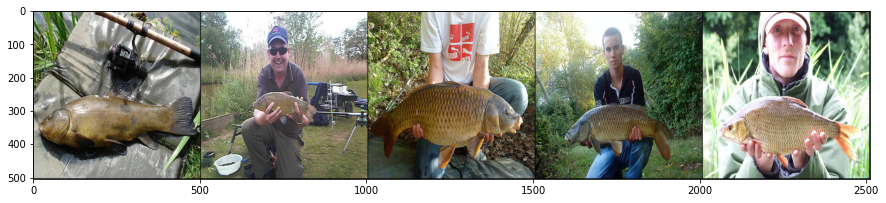

In [5]:
images, labels = iter(data_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), [imagnet_data.classes[i] for i in labels])

In [41]:
from torch.nn.modules.module import Module
from torch.utils.data.dataset import Dataset

class CutMixCrossEntropyLoss(Module):
    def __init__(self, size_average=True):
        super().__init__()
        self.size_average = size_average

    def forward(self, input, target):
        if len(target.size()) == 1:
            target = torch.nn.functional.one_hot(target, num_classes=input.size(-1))
            target = target.float().cuda()
        return cross_entropy(input, target, self.size_average)


def cross_entropy(input, target, size_average=True):
    """ Cross entropy that accepts soft targets
    Args:
         pred: predictions for neural network
         targets: targets, can be soft
         size_average: if false, sum is returned instead of mean
    Examples::
        input = torch.FloatTensor([[1.1, 2.8, 1.3], [1.1, 2.1, 4.8]])
        input = torch.autograd.Variable(out, requires_grad=True)
        target = torch.FloatTensor([[0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
        target = torch.autograd.Variable(y1)
        loss = cross_entropy(input, target)
        loss.backward()
    """
    logsoftmax = torch.nn.LogSoftmax(dim=1)
    if size_average:
        return torch.mean(torch.sum(-target * logsoftmax(input), dim=1))
    else:
        return torch.sum(torch.sum(-target * logsoftmax(input), dim=1))


def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec


def rand_bbox(size, lam):
    if len(size) == 4:
        W = size[2]
        H = size[3]
    elif len(size) == 3:
        W = size[1]
        H = size[2]
    else:
        raise Exception

    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 3, 0, W)
    bby1 = np.clip(cy - cut_h // 3, 0, H)
    bbx2 = np.clip(cx + cut_w // 3, 0, W)
    bby2 = np.clip(cy + cut_h // 3, 0, H)

    return bbx1, bby1, bbx2, bby2

In [73]:
class CutMix(Dataset):
    def __init__(self, dataset, num_class, num_mix=1, beta=1., prob=1.0):
        self.dataset = dataset
        self.num_class = num_class
        self.num_mix = num_mix
        self.beta = beta
        self.prob = prob
    
    def __len__(self) -> int:
        return 5000

    def __getitem__(self, index):
        img, lb = self.dataset[index]
        lb_onehot = onehot(self.num_class, lb)

        for _ in range(self.num_mix):
            r = np.random.rand(1)
            if self.beta <= 0 or r > self.prob:
                continue

            # generate mixed sample
            lam = np.random.beta(self.beta, self.beta)
            rand_index = random.choice(range(len(self)))

            img2, lb2 = self.dataset[rand_index]
            lb2_onehot = onehot(self.num_class, lb2)

            bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
            img[:, bbx1:bbx2, bby1:bby2] = img2[:, bbx1:bbx2, bby1:bby2]
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
            lb_onehot = lb_onehot * lam + lb2_onehot * (1. - lam)

        return img

In [74]:
cutmix = CutMix(data_loader, 1000, num_mix=1, beta=1., prob=1.0)

In [75]:
root = '/content/newdata'
imagnet_data = ImageFolder(root=root, transform=transform)
batch_size = 5

In [76]:
train_loader = torch.utils.data.DataLoader(
                CutMix(imagnet_data, 1000, beta=1.0, prob=1.0, num_mix=1),
                batch_size=batch_size, shuffle=False)

data_loader = torch.utils.data.DataLoader(imagnet_data, batch_size=batch_size, shuffle=False)

In [77]:
len(train_loader)

1000

In [78]:
i=0
for cln_data,(cln_data_,true_label)  in zip(train_loader,data_loader):
    i = i+1
    if i == 3:
        break


In [79]:
from advertorch_examples.utils import _imshow

plt.figure(figsize=(30, 16))
for ii in range(batch_size):
    plt.subplot(2, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(true_label[ii]))

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [80]:
!rm -rf /content/images
!mkdir /content/images

In [ ]:
from torchvision import transforms

for (cln_data_1,true_label), cln_data  in tqdm(zip(data_loader, train_loader)):

    bs_idx = int(true_label.numpy()[0])
    #print(bs_idx)
    for i in range(batch_size):
        unloader = transforms.ToPILImage()
        image = cln_data[i].cpu().clone()  # clone the tensor
        image = image.squeeze(0)  
        image = unloader(image)
        name_idx = 5*(bs_idx) + i
        image.save('images/{}.jpg'.format(name_idx))

In [82]:
print(len(os.listdir('/content/images')))

5000


In [83]:
!zip -r -q images.zip images/*.jpg

In [84]:
!cp -r /content/images.zip '/content/drive/MyDrive/Colab Notebooks/Tianchi/CVPR2021 安全AI挑战者计划第六期：ImageNet无限制对抗攻击 赛道二/'